In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False)  # low dpi (dots per inch) yields small inline figures
results_file = '/scratch/users/jjzhu/tmp_data/intestine.h5ad'
sys.path.insert(0,'/home/users/jjzhu/source_code/aloe/src')
sys.path.insert(0,'./src')

/home/users/jjzhu/.ve/ti/lib/python3.6/site-packages/pandas/compat/__init__.py:84: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


/home/users/jjzhu/.ve/ti/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


Input: 27998 genes; 1383 samples
filtered out 17097 genes that are detectedin less than 10 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/home/users/jjzhu/.ve/ti/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)
/home/users/jjzhu/.pyenv/versions/jupyter3_install/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Use X instead of data, data will be removed in the future.
  if __name__ == '__main__':
/home/users/jjzhu/.pyenv/versions/jupyter3_install/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Use X instead of data, data will be removed in the future.
  if __name__ == '__main__':
/home/users/jjzhu/.pyenv/versions/jupyter3_install/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Use X instead of data, data will be removed in the future.
  # This is added back by InteractiveShellApp.init_path()


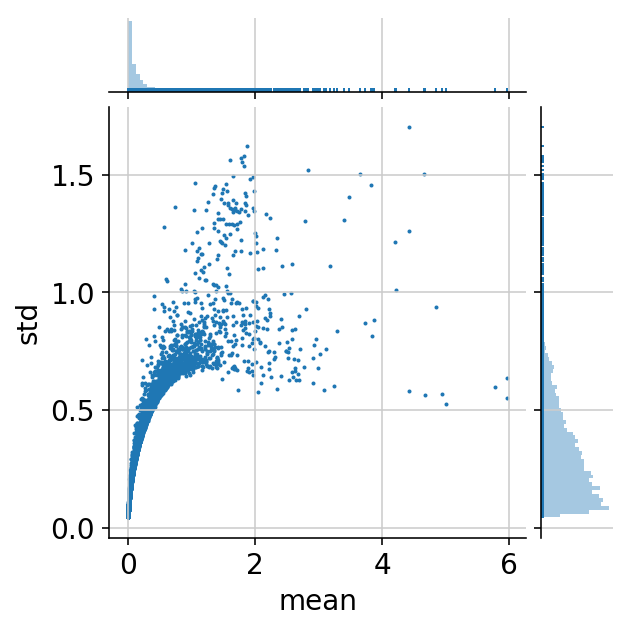

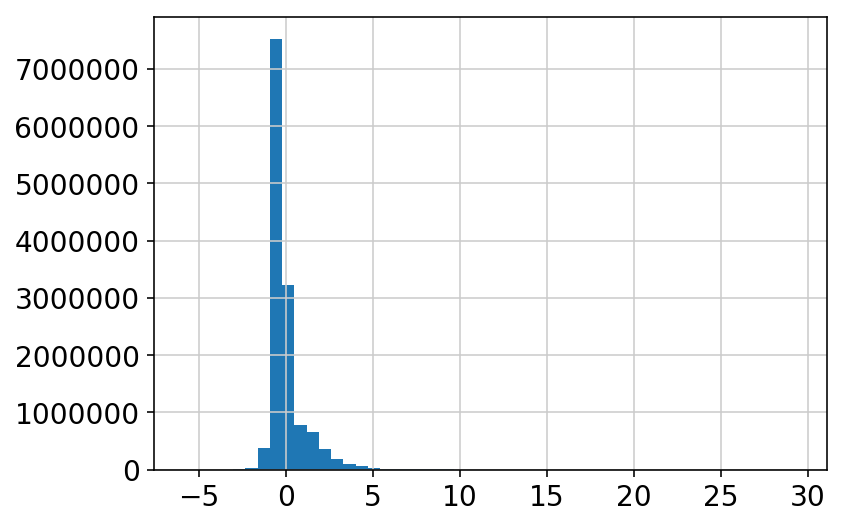

/home/users/jjzhu/.pyenv/versions/jupyter3_install/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Use X instead of data, data will be removed in the future.
  app.launch_new_instance()
/home/users/jjzhu/.pyenv/versions/jupyter3_install/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Use X instead of data, data will be removed in the future.
  app.launch_new_instance()
/home/users/jjzhu/.pyenv/versions/jupyter3_install/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Use X instead of data, data will be removed in the future.


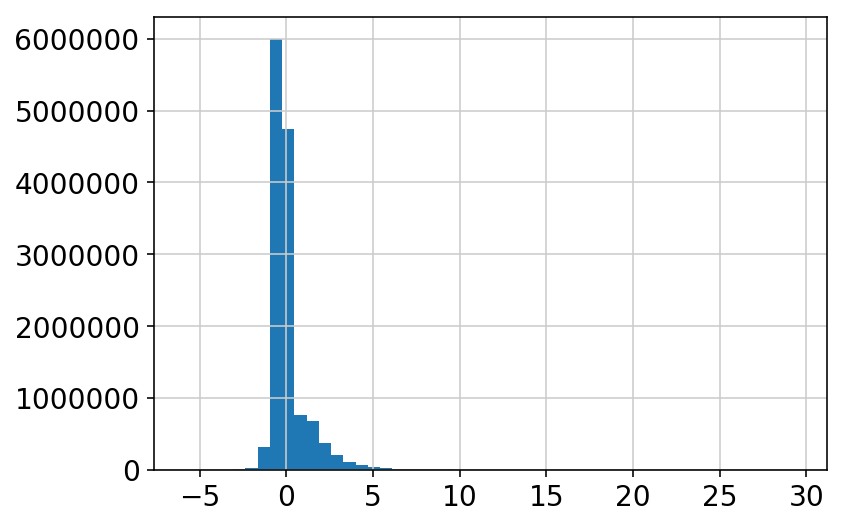

In [2]:
from intestine_info import load_enterocyte_data, output_processed_enterocyte_data
from scrna_utils import transform_filter_anndata
from general_utils import norm_mtx


dat_dir = '/share/PI/sabatti/sc_data/intestine2k'
adata = load_enterocyte_data(dat_dir, verbose=False)
adata = transform_filter_anndata(adata, scale_pfx="original")
adata.data = norm_mtx(adata.data, center=True, scale=True)
fig, ax = plt.subplots(1, 1)
ax.hist(adata.data.flatten(), bins=50)
plt.show()
# add nosie
from sim_utils import add_correlated_noise
noise_struct = {"model": "normal", "block_size": 200, "corr_value": 0.3}
adata.data = add_correlated_noise(adata.data, noise_struct, trunc=False, scale=0.1)
fig, ax = plt.subplots(1, 1)
ax.hist(adata.data.flatten(), bins=50)
plt.show()

In [3]:
from shared_utils import run_paga_clustering, run_paga_pseudotime
start_cell = 'AACACGTAGGGTATCG'
# adata = run_paga_clustering(adata)
adata = run_paga_pseudotime(adata, start_cell)

computing PCA with n_comps = 50
    finished (0:00:12)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99167687 0.9781568  0.96210736 0.9494554  0.91621244
     0.9038892  0.89885193 0.8918751  0.86080533 0.8540361  0.849892
     0.83824444 0.82211316 0.81978387]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:07)


/home/users/jjzhu/.ve/ti/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


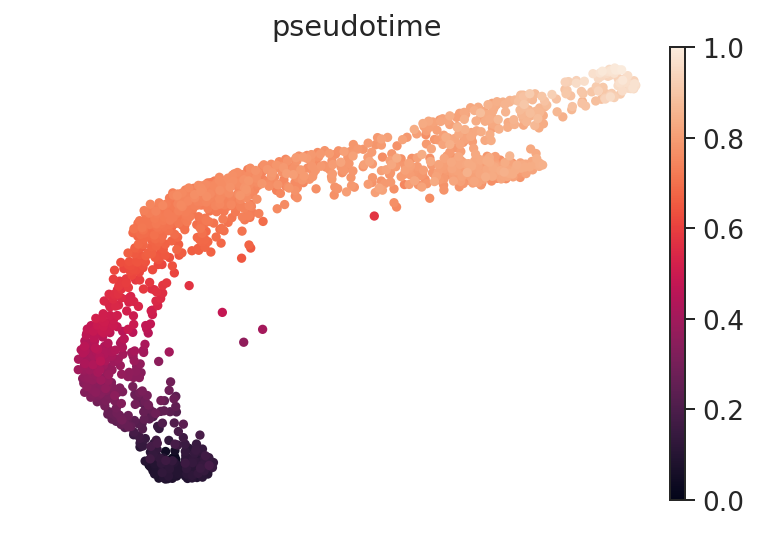

In [4]:
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color=['pseudotime'], legend_loc='on data')

In [5]:
from scipy.stats import spearmanr
from intestine_info import load_original_entero_zonation
zone_vals = load_original_entero_zonation(just_vals=True)
abs(spearmanr(adata.obs['pseudotime'], zone_vals).correlation)

0.9505338031438612

In [15]:
# out_dir = '/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data'
res_dir = "/share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719"
RDIR = os.path.join(res_dir, "entero_data", "simulations", sim_name)
fn = os.path.join(out_dir, 'ti_methods', 'paga_obs_df.csv')
adata.obs.to_csv(fn, index=False)
print('Saved to: {}'.format(fn))

Saved to: /share/PI/sabatti/feat_viz/real_analysis_result/analysis_060719/entero_data/ti_methods/paga_obs_df.csv


In [9]:
adata.obs.head()

,n_genes,n_counts,cell_id,pseudotime
AAACCTGGTAAGTTCC,2033,6751.0,AAACCTGGTAAGTTCC,0.674999
AAACGGGCACCAACCG,1135,3754.0,AAACGGGCACCAACCG,0.782643
AAACGGGTCACTGGGC,2559,9224.0,AAACGGGTCACTGGGC,0.458948
AAAGATGGTGGACGAT,1706,5144.0,AAAGATGGTGGACGAT,0.703316
AAAGATGGTTCGGGCT,3079,11475.0,AAAGATGGTTCGGGCT,0.320673
